[comment]: <> "LTeX: language=fr"
# <center>Dissection d'un transformer</center>
## <center>Jean-Philippe Magué, IXXI</center>
### <center>21 juin 2024</center>

[comment]: <> "LTeX: language=fr"
Ce notebook propose une vision de "haut niveau" du fonctionnement du modèle [GPT2](https://huggingface.co/docs/transformers/en/model_doc/gpt2), c'est-à-dire en regardant les entrées et les sorties, mais sans rentrer dans le fonctionnement interne. 

Il utilise la bibliothèque [transformers](https://huggingface.co/docs/transformers/en/index) de [HuggingFace](https://huggingface.co/)

# Initialisation

In [2]:
from transformers import pipeline
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import matplotlib.pyplot as plt
import torch

In [3]:
torch.set_grad_enabled(False) #no training today!

In [15]:
model_name = 'openai-community/gpt2'

In [24]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
gpt2 = GPT2LMHeadModel.from_pretrained(model_name,device_map="auto",pad_token_id=tokenizer.eos_token_id)
device = gpt2.device
device

device(type='mps', index=0)

# Génération de texte

In [25]:
prompt = 'the cat sat on the'

![](img/tokenization/tokenization.001.png)

## Tokenisation

In [26]:
input = tokenizer(prompt, return_tensors="pt").to(device)
input

{'input_ids': tensor([[1169, 3797, 3332,  319,  262]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1]], device='mps:0')}

In [27]:
for token in input['input_ids'][0]:
    print(f'|{tokenizer.decode(token)}| -> {token}')

|the| -> 1169
| cat| -> 3797
| sat| -> 3332
| on| -> 319
| the| -> 262


In [54]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1)

In [29]:
output

tensor([[1169, 3797, 3332,  319,  262, 4314]], device='mps:0')

In [30]:
for token in output[0]:
    print(f'{token} -> |{tokenizer.decode(token)}|')

1169 -> |the|
3797 -> | cat|
3332 -> | sat|
319 -> | on|
262 -> | the|
4314 -> | floor|


In [55]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,return_dict_in_generate=True, output_scores=True)

In [56]:
output['scores']

(tensor([[-93.6302, -91.2279, -95.6219,  ..., -95.8761, -95.7496, -93.2641]],
        device='mps:0'),)

In [97]:
scores = output['scores'][0].cpu().detach().numpy()

### Score des 10 premiers tokens

In [98]:
for i in range(10):
    print(f'|{tokenizer.decode(i)}| -> {scores[0,i]:.4f}')

|!| -> -93.6302
|"| -> -91.2279
|#| -> -95.6219
|$| -> -96.1859
|%| -> -95.5137
|&| -> -96.0170
|'| -> -92.7750
|(| -> -92.5709
|)| -> -90.8867
|*| -> -93.0254


On peut transformer ces scores en probabilités via une fonction softmax :

$\sigma(x_i)=\frac{e^{x_i}}{\sum{e^{x_j}}}$

In [88]:
probs = torch.nn.functional.softmax(torch.tensor(scores),dim=1)[0].numpy()
probs

array([1.9344670e-07, 2.1372703e-06, 2.6397579e-08, ..., 2.0473150e-08,
       2.3234190e-08, 2.7896203e-07], dtype=float32)

In [93]:
for i in range(10):
    print(f'|{tokenizer.decode(i)}| -> {probs[i]:.8f}')  

|!| -> 0.00000019
|"| -> 0.00000214
|#| -> 0.00000003
|$| -> 0.00000002
|%| -> 0.00000003
|&| -> 0.00000002
|'| -> 0.00000045
|(| -> 0.00000056
|)| -> 0.00000301
|*| -> 0.00000035


In [96]:
tokens_sorted_by_prob=sorted(list(zip([tokenizer.decode(i) for i in range(len(probs))],probs)), key=lambda x: x[1], reverse=True)
for i in range(10):
    print(f'{tokens_sorted_by_prob[i][0]} -> {tokens_sorted_by_prob[i][1]:.3f}')

 floor -> 0.067
 couch -> 0.058
 bed -> 0.055
 ground -> 0.043
 edge -> 0.041
 bench -> 0.035
 other -> 0.034
 table -> 0.032
 sofa -> 0.023
 back -> 0.015


Le modèle choisi le token ayant le plus 

# Brouillon

In [3]:
pipe = pipeline(model=model_name, device_map='auto')

/Users/jmague/mambaforge/envs/formation_LLM/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [42]:
prompt = "Hi language model, how are you"


In [27]:
pipe(prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hi language model, how are you going to get it?\n\nCurtis Molyneux: Well, we really have a very specific language model where you will want to use three types of code, that's what we're building for"}]

In [10]:
device=model.device

{'input_ids': [1169, 3797, 3332, 319, 262], 'attention_mask': [1, 1, 1, 1, 1]}

|the| -> 1169
| cat| -> 3797
| sat| -> 3332
| on| -> 319
| the| -> 262


In [46]:
input = tokenizer(prompt, return_tensors="pt").to(device)
input

{'input_ids': tensor([[1169, 3797, 3332,  319,  262]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1]], device='mps:0')}

In [52]:
output = model.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [53]:
output

tensor([[1169, 3797, 3332,  319,  262, 4314]], device='mps:0')

In [54]:
for token in model_output[0]:
    print(f'{token} -> |{tokenizer.decode(token)}|')

1169 -> |the|
3797 -> | cat|
3332 -> | sat|
319 -> | on|
262 -> | the|
4314 -> | floor|


In [47]:
model.generation_config

GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

In [52]:
model_output = model.generate(**model_input, output_scores=True,return_dict_in_generate=True, max_new_tokens=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [44]:
model_output['scores'][0]

NameError: name 'model_output' is not defined

In [67]:
probs = torch.nn.functional.softmax(model_output['scores'][0][0],dim=0).cpu().detach().numpy()

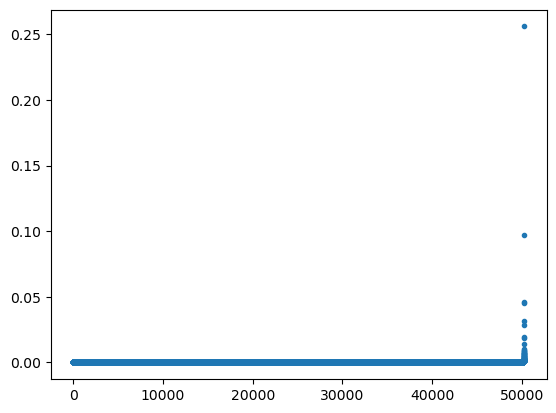

In [68]:
plt.plot(sorted(probs),'.')

In [86]:
for token in torch.topk(model_output['scores'][0], k=5).indices[0]:
    print(f'token {token} : |{tokenizer.decode(token)}| p={probs[token]:.4f}')


token 534 : | your| p=0.2561
token 262 : | the| p=0.0972
token 257 : | a| p=0.0461
token 428 : | this| p=0.0454
token 326 : | that| p=0.0316


In [33]:
prompt = 'the cat sat on the'

In [34]:
tokenizer(prompt)

{'input_ids': [1169, 3797, 3332, 319, 262], 'attention_mask': [1, 1, 1, 1, 1]}

In [39]:
input_ids=tokenizer(prompt, return_tensors="pt").to(device)['input_ids']

In [41]:
model.generate(input_ids=input_ids,attention_mask=max_new_tokens=1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[1169, 3797, 3332,  319,  262, 4314]], device='mps:0')